<img src="../images/HKA_MMT_Logo.png" width="350">

# <font color='2869AF'> Künstliche Intelligenz </font>

### <font color='2869AF'> Transfer Learning </font>

### Frau Prof.Dr.-Ing. habil. Catherina Burghart

## <font color='2869AF'> Inhalt </font>

In diesem Notebook wird Transfer Learning erläutert und gezeigt, wie es angewandt werden kann, um den Datensatz 'Cats and Dogs' zu klassifizieren.


### <font color='2869AF'> Warum Transfer Learning? </font>

In vorherigen Kapitel wurden gezeigt, dass überwachte Lernverfahren wie   CNN's  gut funktionieren, um Bilder zu klassifizieren. Das Trainieren der Netze geht auch mit einfachen Rechnern ohne große Rechenleistung noch in einer akzeptablen Zeit. 
Wenn aber ein Datensatz vorliegt, welcher eine höhere Anzahl an Klassen aufweist (100, 1000), würde eine deutlich höhere Rechenleistung benötigt werden und vor allem auch deutlich mehr Trainingsdaten. 
Hier kommt das Transfer Learning zur Anwendung.  Beim Transfer Learning werden Netze verwendet, welche schon vortrainierte wurden und bereits die gewünschten Klassen enthalten. Der Datensatz, welcher zum trainierender Netze verwendet wurde, ist der ImageNet Datensatz aus dem Jahre 2010, mit 150 000 Bildern und 1000 verschieden Klassen. Unter Verwendung dieser trainierten Netze kann der benötigte Rechenaufwand als auch die Menge der benötigten Trainingsdaten deutlich verringert werden.


### <font color='2869AF'> Importieren des Datensatzes </font>

Der Datensatz kann von der Website kaggle unter folgendem Link heruntergeladen werden: https://www.kaggle.com/datasets/chetankv/dogs-cats-images


In [8]:
import os 
import matplotlib.pyplot as plt 


# setzen des Basis Verzeichnisses 
basedir = r'photos_transfer_learning'

IMAGE_WIDTH=125
IMAGE_HEIGHT=125
IMAGE_CHANNELS=3


# anlegen eines dictionary für die Verzeichnisse
dir_dict = {
    'train': os.path.join(basedir,'training_set'),
    'test': os.path.join(basedir,'test_set'),
    'train_onion': os.path.join(basedir,'training_set','onion'),
    'train_carrot': os.path.join(basedir,'training_set','carrot'),
    'train_potato': os.path.join(basedir,'training_set','potato'),
    'test_onion': os.path.join(basedir,'test_set','onion'),
    'test_carrot': os.path.join(basedir,'test_set','carrot'),
    'test_potato': os.path.join(basedir,'test_set','potato')
    }


Überprüfen, ob für jede Klasse 1000 Testbilder und 4000 Trainingsbilder vorliegen.


In [9]:
print ('Anzahl der Zwiebelbilder (Training):',len(os.listdir(dir_dict['train_onion'])))
print ('Anzahl der Karottenbilder (Training):',len(os.listdir(dir_dict['train_carrot'])))
print ('Anzahl der Kartoffelbilder (Training):',len(os.listdir(dir_dict['train_potato'])))

print ('Anzahl der Zwiebelbilder (Test):',len(os.listdir(dir_dict['test_onion'])))
print ('Anzahl der Karottenbilder (Test):',len(os.listdir(dir_dict['test_carrot'])))
print ('Anzahl der Kartoffelbilder (Test):',len(os.listdir(dir_dict['test_potato'])))


Anzahl der Zwiebelbilder (Training): 976
Anzahl der Karottenbilder (Training): 681
Anzahl der Kartoffelbilder (Training): 1351
Anzahl der Zwiebelbilder (Test): 100
Anzahl der Karottenbilder (Test): 100
Anzahl der Kartoffelbilder (Test): 100


### <font color='2869AF'> Trainiertes Netz einbinden </font>

Als trainiertes Netz verwenden, wir das Inception V3 welches mit dem ImageNet Datensatz trainiert wurde. Beim Laden des Netzes geben wir mit **weights='imagenet'** an, dass die trainierten Gewichte auf Basis des ImageNet Datensatzes mit geladen werden sollen. 
Mit **'include_top=False'** wird angegeben, dass nur den Kodierungsblock geladen und der Prädikationsblock ausgelassen wird. Der Prädikationsblock wird für den Anwendungsfall selbst definiert


In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers

In [15]:
model = models.Sequential()
# definieren des Basis Models 
base_model = InceptionV3(weights='imagenet',include_top=False, input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS))

# hinzufügen des InceptionV3 Netzes zum Modell 
model.add(base_model)

# definieren des Prädikationsblock 
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# deaktivieren des Training des Basis Modells 
base_model.trainable = False 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 512)               131584    
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24032289 (91.68 MB)
Trainable params: 2229505 (8.50 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


Bei der Zusammenfassung des Netzes fällt auf, dass nur rund Eindrittel aller Parameter trainierbar sind, was daran liegt, dass das Trainieren der Gewichte des Basismodells deaktiviert wurde. Jetzt müssen noch die Verlustfunktion des Optimierungsverfahrens und die Metriken definiert werden, bevor das Netz trainiert werden kann.


In [16]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(1e-4),metrics=['acc'])

### <font color='2869AF'> Vorbereiten der Daten </font>

Um die Daten vorzubereiten, verwenden wir den **ImageDataGenerator()** von **tensorflow.keras**. 
Um den Datensatz zu vergrößern, verwenden wir Data Augmentation (Drehen, Rotieren). Wichtig ist, dass die Pixelwerte auf den Bereich [0,1] normiert werden und dass die Bildgröße auf die Eingangschicht des Netzes [200,200,3] angepasst wird.


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# rescalen und Data Augmentation für Trainingsdaten 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
    )
# rescalen der Testdaten 
test_datagen = ImageDataGenerator(
    rescale = 1./255
    )

# laden der Bilder über den ImageDataGenerator 
train_generator = train_datagen.flow_from_directory(
    dir_dict['train'],
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size  = 20,
    class_mode = 'binary' 
)

test_generator = test_datagen.flow_from_directory(
    dir_dict['test'],
    target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size  = 20,
    class_mode = 'binary' 
)

Found 3008 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


### <font color='2869AF'> Trainieren des Netzes </font>


In [19]:
history = model.fit(train_generator,
steps_per_epoch=100,
epochs = 5, #40
validation_data = test_generator,
validation_steps=50)


Epoch 1/5
100/100 [==============================] - 22s 220ms/step - loss: -2390.7163 - acc: 0.3737
Epoch 2/5
100/100 [==============================] - 21s 212ms/step - loss: -5444.8486 - acc: 0.3888
Epoch 3/5
100/100 [==============================] - 23s 233ms/step - loss: -10446.6191 - acc: 0.3750
Epoch 4/5
100/100 [==============================] - 24s 241ms/step - loss: -17804.2012 - acc: 0.3763
Epoch 5/5
100/100 [==============================] - 27s 274ms/step - loss: -27484.1406 - acc: 0.3682


In [20]:
# Das Modell kann zum Vergleichen von unterschiedlichen Parametern des Prädikationsblocks abgespeichert werden

# model.save('cats_dogs_1.h5')


### <font color='2869AF'> Auswerten des Netzes </font>

Um die Qualität des Netzes beurteilen zu können, können die verschiedenen Metriken ausgegeben werden.


In [22]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 640x480 with 0 Axes>

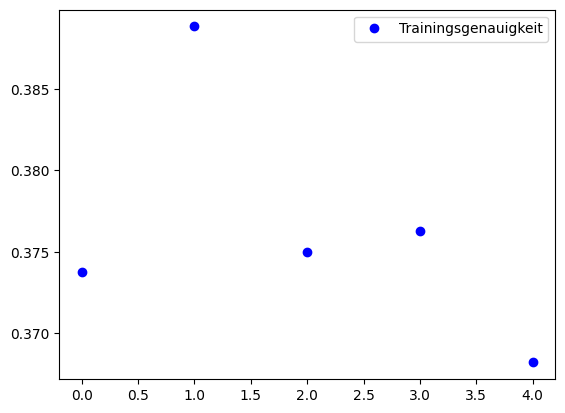

<Figure size 640x480 with 0 Axes>

In [23]:
plt.plot(epochs,acc,'bo',label='Trainingsgenauigkeit')
# plt.plot(epochs,val_acc,'b',label='Validierungsgenauigkeit')
# plt.title('Trainings und  Validierungsgenauigkeit')
plt.legend()

plt.figure()

<Figure size 640x480 with 0 Axes>

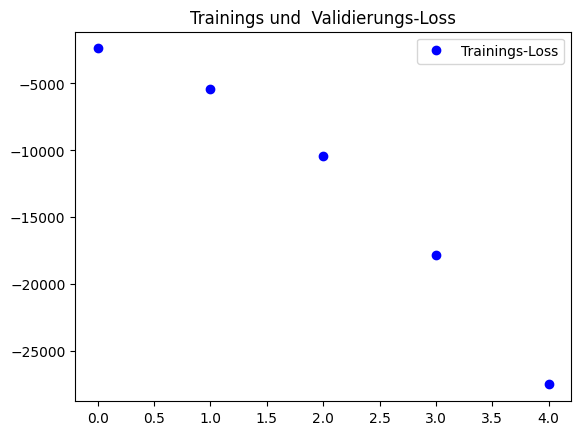

<Figure size 640x480 with 0 Axes>

In [24]:
plt.plot(epochs,loss,'bo',label='Trainings-Loss')
# plt.plot(epochs,val_loss,'b',label='Validierungs-Loss')
plt.title('Trainings und  Validierungs-Loss')
plt.legend()

plt.figure()

Durch das vortrainierte Netz erhalten wir schon zu Beginn eine große Validierungsgenauigkeit von 96 %. Wohingegen die Trainingsgenauigkeit langsam ansteigt.Bei Verlauf des Verlustes verhält es sich ähnlich wie beim Verlauf der Genauigkeit.
